# Biểu đồ Waffle, Word Cloud, và Sơ đồ hồi quy

In [1]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
from PIL import Image # converting images into arrays

# !conda install -c anaconda xlrd --yes

In [2]:
df_can = pd.read_excel('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/Canada.xlsx',
                       sheet_name='Canada by Citizenship',
                       skiprows=range(20),
                       skipfooter=2)

print('Data downloaded and read into a dataframe!')

Data downloaded and read into a dataframe!


In [3]:
df_can.head()

,Type,Coverage,OdName,AREA,AreaName,REG,RegName,DEV,DevName,1980,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Immigrants,Foreigners,Afghanistan,935,Asia,5501,Southern Asia,902,Developing regions,16,...,2978,3436,3009,2652,2111,1746,1758,2203,2635,2004
1,Immigrants,Foreigners,Albania,908,Europe,925,Southern Europe,901,Developed regions,1,...,1450,1223,856,702,560,716,561,539,620,603
2,Immigrants,Foreigners,Algeria,903,Africa,912,Northern Africa,902,Developing regions,80,...,3616,3626,4807,3623,4005,5393,4752,4325,3774,4331
3,Immigrants,Foreigners,American Samoa,909,Oceania,957,Polynesia,902,Developing regions,0,...,0,0,1,0,0,0,0,0,0,0
4,Immigrants,Foreigners,Andorra,908,Europe,925,Southern Europe,901,Developed regions,0,...,0,0,1,1,0,0,0,0,1,1


In [4]:
# print the dimensions of the dataframe
print(df_can.shape)

(195, 43)


Dọn dẹp dữ liệu. Chúng ta sẽ tạo một số thay đổi đối với tập dữ liệu gốc để dễ tạo các hình ảnh trực quan hơn. Tham khảo Introduction to Matplotlib and Line Plots và Area Plots, Histograms, and Bar Plots để biết thêm mô tả hi tiết về quá trình xử lý.

In [5]:
# clean up the dataset to remove unnecessary columns (eg. REG) 
df_can.drop(['AREA','REG','DEV','Type','Coverage'], axis = 1, inplace = True)

# let's rename the columns so that they make sense
df_can.rename (columns = {'OdName':'Country', 'AreaName':'Continent','RegName':'Region'}, inplace = True)

# for sake of consistency, let's also make all column labels of type string
df_can.columns = list(map(str, df_can.columns))

# set the country name as index - useful for quickly looking up countries using .loc method
df_can.set_index('Country', inplace = True)

# add total column
df_can['Total'] =  df_can.sum (axis = 1)

# years that we will be using in this lesson - useful for plotting later on
years = list(map(str, range(1980, 2014)))
print ('data dimensions:', df_can.shape)

data dimensions: (195, 38)


C:\Users\phatk\AppData\Local\Temp\ipykernel_27612\2754968886.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_can['Total'] =  df_can.sum (axis = 1)


# Trực quan hóa dữ liệu bằng Matplotlib

In [6]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # needed for waffle Charts

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.6.0


# Biểu đồ Waffle

Biểu đồ waffle là một hình ảnh trực quan khá thú vị thường được tạo ra để hiển thị tiến trình đạy được mục đích. Nó thường là một lựa chọn hiệu quả khi bạn đang cố thêm những tính năng trực quan hóa thú vị vào một hình ảnh chủ yếu chứa các hàng như trong Excel.

Hãy xem lại các case study trong bài học trước về Đan Mạch, Na Uy, và Thụy Điển.

In [7]:
# let's create a new dataframe for these three countries 
df_dsn = df_can.loc[['Denmark', 'Norway', 'Sweden'], :]

# let's take a look at our dataframe
df_dsn

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Denmark,Europe,Northern Europe,Developed regions,272,293,299,106,93,73,93,...,62,101,97,108,81,92,93,94,81,3901
Norway,Europe,Northern Europe,Developed regions,116,77,106,51,31,54,56,...,57,53,73,66,75,46,49,53,59,2327
Sweden,Europe,Northern Europe,Developed regions,281,308,222,176,128,158,187,...,205,139,193,165,167,159,134,140,140,5866


Thật không may, không giống như R, biểu đồ waffle không được tích hợp bất kể thư viện trực quan hóa Python nào. Do đó, chúng ta sẽ học cách tạo chúng từ đầu.

**Bước 1. Bước đầu tiên để tạo biểu đồ waffle xác định phần trăm của mỗi loại so với tổng.**

In [8]:
# compute the proportion of each category with respect to the total
total_values = sum(df_dsn['Total'])
category_proportions = [(float(value) / total_values) for value in df_dsn['Total']]

# print out proportions
for i, proportion in enumerate(category_proportions):
    print (df_dsn.index.values[i] + ': ' + str(proportion))

Denmark: 0.32255663965602777
Norway: 0.1924094592359848
Sweden: 0.48503390110798744


**Bước 2. Bước thứ 2 là xác định tổng kích thước của biểu đồ waffle.**

In [9]:
width = 40 # width of chart
height = 10 # height of chart

total_num_tiles = width * height # total number of tiles

print ('Total number of tiles is ', total_num_tiles)

Total number of tiles is  400


**Bước 3. Dùng tỉ lệ phần trăm của mỗi loại để xác định số lượng tiêu đề tương ứng của nó.**

In [10]:
# compute the number of tiles for each catagory
tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

# print out number of tiles per category
for i, tiles in enumerate(tiles_per_category):
    print (df_dsn.index.values[i] + ': ' + str(tiles))

Denmark: 129
Norway: 77
Sweden: 194


Dựa trên tỉ lệ đã tính, Đan Mạch sẽ chiếm 129 tiêu đề trong biểu đồ waffle, Na Uy chiếm 77, và Thụy Điển chiếm 194.

**Bước 4. Bước thứ 4 là tạo ra một ma trận giống với biểu đồ waffle và phân bố các thành phần của nó.**

In [11]:
# initialize the waffle chart as an empty matrix
waffle_chart = np.zeros((height, width))

# define indices to loop through waffle chart
category_index = 0
tile_index = 0

# populate the waffle chart
for col in range(width):
    for row in range(height):
        tile_index += 1

        # if the number of tiles populated for the current category is equal to its corresponding allocated tiles...
        if tile_index > sum(tiles_per_category[0:category_index]):
            # ...proceed to the next category
            category_index += 1       
            
        # set the class value to an integer, which increases with class
        waffle_chart[row, col] = category_index
        
print ('Waffle chart populated!')

Waffle chart populated!


In [12]:
waffle_chart

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
   

Đúng như kì vọng, ma trận có 3 loại và tổng số lượng thực thể của từng loại khớp với tổng số tiêu đề được phân bố cho mỗi loại.

**Bước 5. Ánh xạ ma trận biểu đồ waffle với một hình ảnh.**

<Figure size 640x480 with 0 Axes>

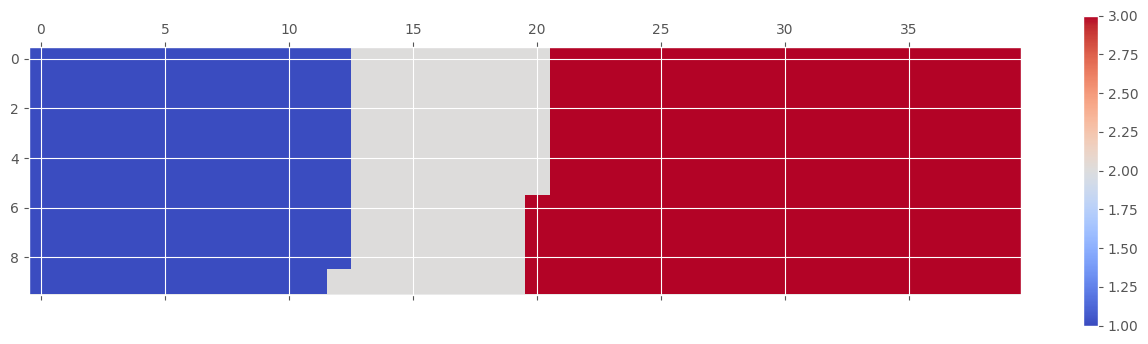

In [13]:
# instantiate a new figure object
fig = plt.figure();

# use matshow to display the waffle chart
colormap = plt.cm.coolwarm;
plt.matshow(waffle_chart, cmap=colormap);
plt.colorbar();

**Bước 6. Làm đẹp biểu đồ.**

<Figure size 640x480 with 0 Axes>

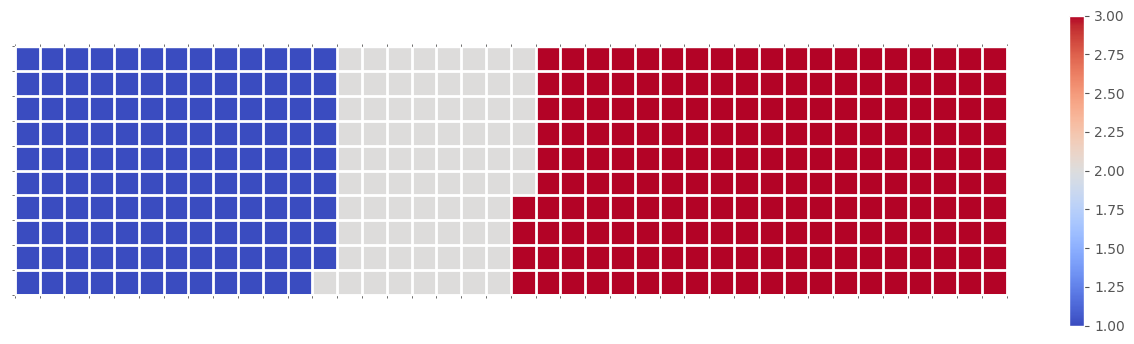

In [14]:
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.coolwarm
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()

# get the axis
ax = plt.gca()

# set minor ticks
ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
# add gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2);

plt.xticks([]);
plt.yticks([]);

**Bước 7. Tạo phần chú thích và thêm nó vào biểu đồ.**

<Figure size 640x480 with 0 Axes>

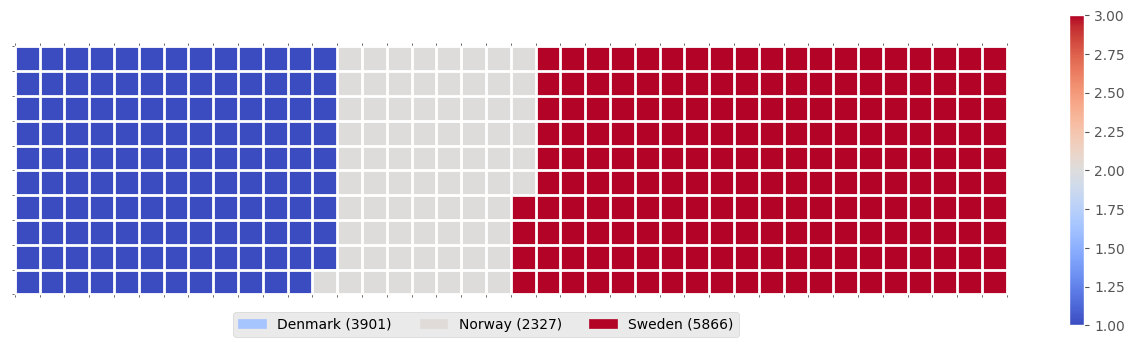

In [15]:
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.coolwarm
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()

# get the axis
ax = plt.gca()

# set minor ticks
ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
# add gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

plt.xticks([])
plt.yticks([])

# compute cumulative sum of individual categories to match color schemes between chart and legend
values_cumsum = np.cumsum(df_dsn['Total'])
total_values = values_cumsum[len(values_cumsum) - 1]

# create legend
legend_handles = []
for i, category in enumerate(df_dsn.index.values):
    label_str = category + ' (' + str(df_dsn['Total'][i]) + ')'
    color_val = colormap(float(values_cumsum[i])/total_values)
    legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

# add legend to chart
plt.legend(handles=legend_handles,
           loc='lower center', 
           ncol=len(df_dsn.index.values),
           bbox_to_anchor=(0., -0.2, 0.95, .1)
          )

Nếu lặp lại cả 7 bước này mỗi lần chúng ta tạo một biểu đồ `waffle` thì thật không hiệu quả. Hãy kết hợp cả 7 bước này vào một hàm gọi là _create_waffle_chart_. Hàm này sẽ lấy các tham số sau làm input:

> 1.  **categories**: Các loại hoặc lớp duy nhất trong khung dữ liệu.
> 2.  **values**: Các giá trị tương ứng với các loại hoặc các lớp.
> 3.  **height**: Xác định chiều cao của biểu đồ waffle.
> 4.  **width**: Xác định chiều rộng của biểu đồ waffle.
> 5.  **colormap**: Colormap class
> 6.  **value_sign**: Để làm cho hàm của chúng ta dễ tổng quát hơn, chúng ta sẽ thêm tham số này để giải quyết các kí hiệu có thể được liên kết với một giá trị chẳng hạn như %, $, v.v. **value_sign** có giá trị mặc định là một xâu kí tự rỗng.

In [16]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (df_dsn.index.values[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    colormap = plt.cm.coolwarm
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        color_val = colormap(float(values_cumsum[i])/total_values)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )

Bây giờ, để tạo một biểu đồ waffle, tất cả những gì chúng ta cần làm là gọi hàm create_waffle_chart. Hãy xác định các tham số input:

Total number of tiles is 400
Denmark: 129
Norway: 77
Sweden: 194


<Figure size 640x480 with 0 Axes>

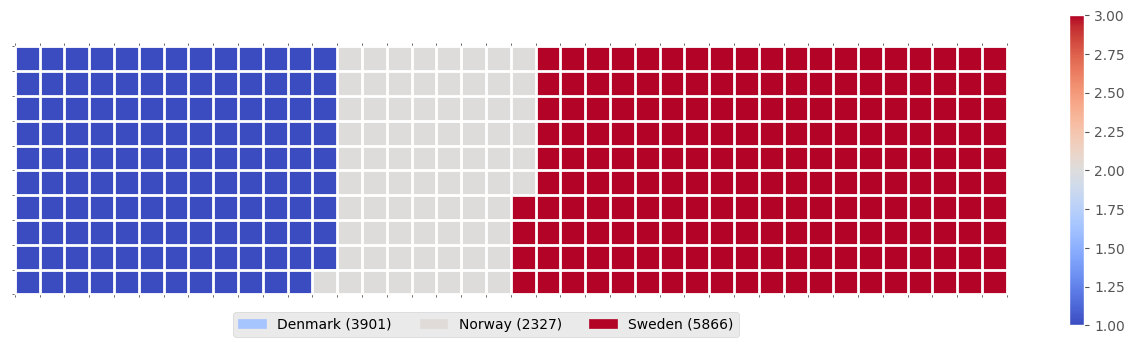

In [17]:
width = 40 # width of chart
height = 10 # height of chart

categories = df_dsn.index.values # categories
values = df_dsn['Total'] # correponding values of categories

colormap = plt.cm.coolwarm # color map class

create_waffle_chart(categories, values, height, width, colormap)

## Word Clouds

Đám mây Word (hay còn gọi là text cloud hoặc tag cloud) hoạt động rất đơn giản: từ càng cụ thể xuất hiện trong nguồn dữ liệu văn bản (như là lời nói, blog post, hoặc cơ sở dữ liệu), thì nó sẽ xuất hiện càng lớn và càng đậm trong word cloud.

In [18]:
# install wordcloud
#!conda install -c conda-forge wordcloud==1.4.1 --yes
# pip install wordcloud

# !pip3 install wordcloud==1.8.1

# import package and its set of stopwords

from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Wordcloud is installed and imported!


`Word` cloud thường được sử dụng để hiển thị các phân tích cấp độ cao và trực quan hóa các dữ liệu văn bản. Chính xác, chúng ta hãy tìm hiểu kỹ từ tập dữ liệu nhập cư và làm việc với một ví dụ liên quan đến việc phân tích dữ liệu văn bản. Hãy thử phân tích một cuốn tiểu thuyết ngắn được viết bởi **Lewis Carroll** có tên _Alice's Adventures in Wonderland_. Hãy tiếp tục và tải file _.txt_ của cuốn tiểu thuyết.


In [19]:
import urllib

# open the file and read it into a variable alice_novel
alice_novel = urllib.request.urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/alice_novel.txt').read().decode("utf-8")

In [20]:
''' 
# download file and save as alice_novel.txt
!wget --quiet "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/alice_novel.txt"

# open the file and read it into a variable alice_novel
alice_novel = open('alice_novel.txt', 'r').read()
    
print ('File downloaded and saved!')

'''

' \n# download file and save as alice_novel.txt\n!wget --quiet "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/alice_novel.txt"\n\n# open the file and read it into a variable alice_novel\nalice_novel = open(\'alice_novel.txt\', \'r\').read()\n    \nprint (\'File downloaded and saved!\')\n\n'

In [21]:
# Tiếp theo, hãy sử dụng các từ dừng (stopword) mà chúng tôi đã nhập từ word_cloud. Chúng tôi sử dụng hàm set để loại bỏ bất kỳ từ dừng thừa nào.

stopwords = set(STOPWORDS)

Tạo một đối tượng word cloud và tạo một word cloud. Để đơn giản, hãy tạo một word cloud chỉ sử dụng 2000 từ đầu tiên của tiểu thuyết.

In [22]:
# instantiate a word cloud object
alice_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
alice_wc.generate(alice_novel);

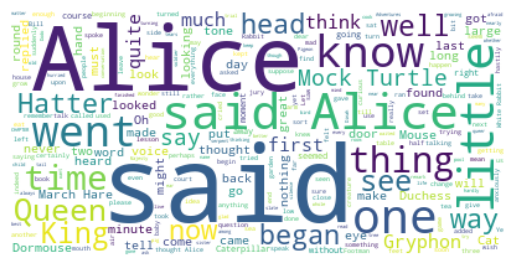

In [23]:
# display the word cloud
plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Thật thú vị! Trong 2000 từ đầu tiên của tiểu thuyết, các từ thông dụng nhất là Alice, said, little, Queen, v.v. Hãy đặt lại kích thước đám mây để chúng ta có thể thấy các từ ít xuất hiện rõ ràng hơn.

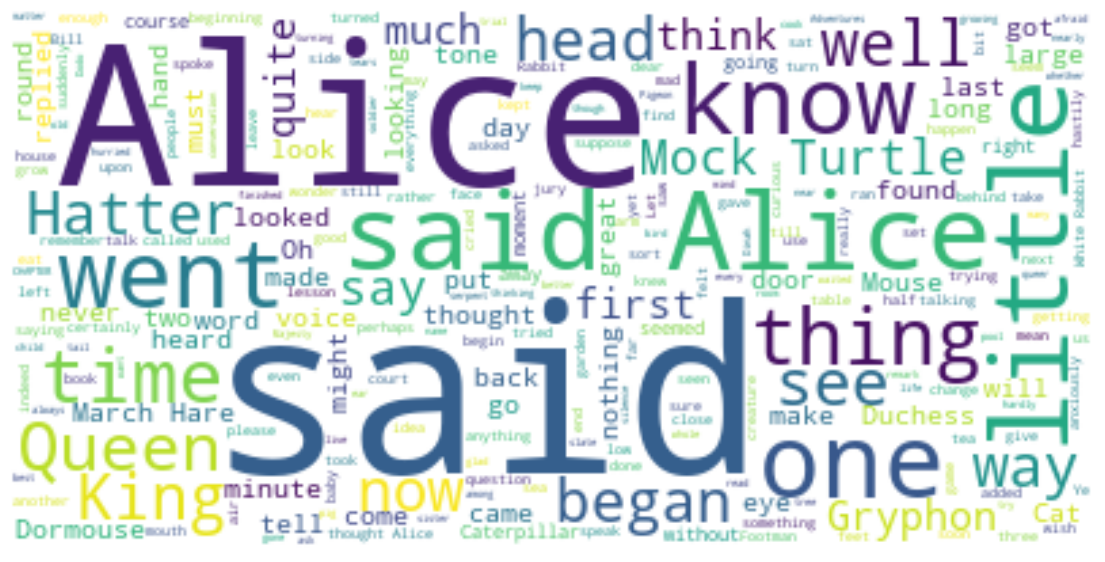

In [24]:
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

# display the cloud
plt.imshow(alice_wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

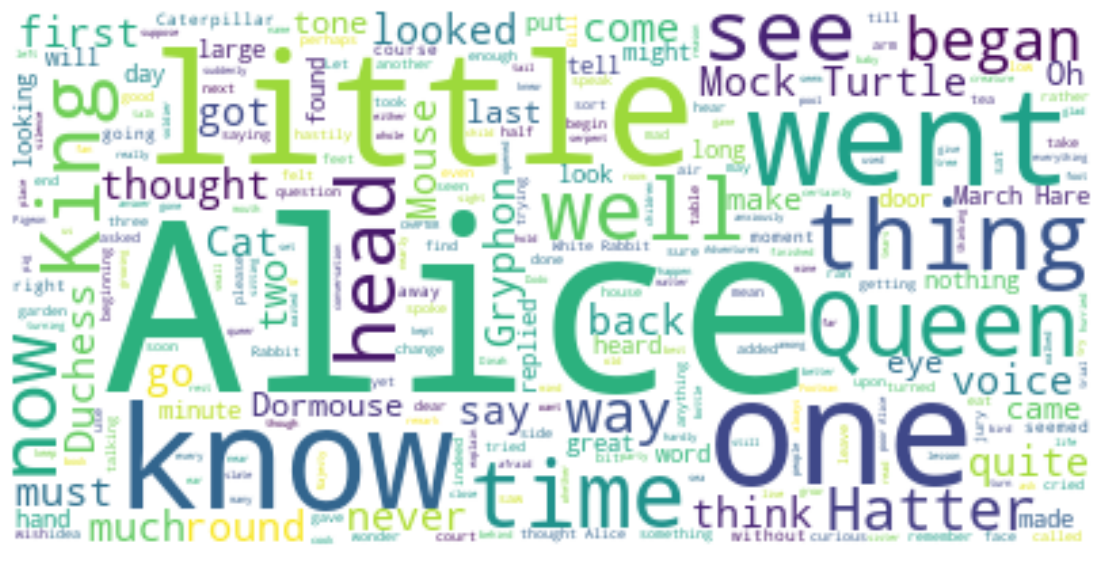

In [25]:
stopwords.add('said') # add the words said to stopwords

# re-generate the word cloud
alice_wc.generate(alice_novel)

# display the cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Rất ấn tượng!

Thật không may, dữ liệu immmigration của chúng ta không có bất kỳ dữ liệu văn bản nào, nhưng nếu muốn thì sẽ có cách. Hãy tạo dữ liệu văn bản mẫu từ tập dữ liệu immmigration của chúng ta, chẳng hạn như dữ liệu văn bản gồm 90 từ.

Hãy nhớ lại dữ liệu của chúng ta trông như thế nào

In [26]:
df_can.head()

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Asia,Southern Asia,Developing regions,16,39,39,47,71,340,496,...,3436,3009,2652,2111,1746,1758,2203,2635,2004,58639
Albania,Europe,Southern Europe,Developed regions,1,0,0,0,0,0,1,...,1223,856,702,560,716,561,539,620,603,15699
Algeria,Africa,Northern Africa,Developing regions,80,67,71,69,63,44,69,...,3626,4807,3623,4005,5393,4752,4325,3774,4331,69439
American Samoa,Oceania,Polynesia,Developing regions,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6
Andorra,Europe,Southern Europe,Developed regions,0,0,0,0,0,0,2,...,0,1,1,0,0,0,0,1,1,15


In [27]:
# Và tổng dân nhập cư từ 1980 đến 2013 là bao nhiêu?

total_immigration = df_can['Total'].sum()
total_immigration

6409153

Sử dụng các quốc gia có tên một từ, hãy sao chép tên của mỗi quốc gia dựa trên mức độ đóng góp của họ vào tổng lượng nhập cư.

In [28]:
max_words = 90
word_string = ''
for country in df_can.index.values:
    # check if country's name is a single-word name
    if len(country.split(' ')) == 1:
        repeat_num_times = int(df_can.loc[country, 'Total']/float(total_immigration)*max_words)
        word_string = word_string + ((country + ' ') * repeat_num_times)
                                     
# display the generated text
word_string

'China China China China China China China China China Colombia Egypt France Guyana Haiti India India India India India India India India India Jamaica Lebanon Morocco Pakistan Pakistan Pakistan Philippines Philippines Philippines Philippines Philippines Philippines Philippines Poland Portugal Romania '

In [29]:
# create the word cloud
wordcloud = WordCloud(background_color='white').generate(word_string)

print('Word cloud created!')

Word cloud created!


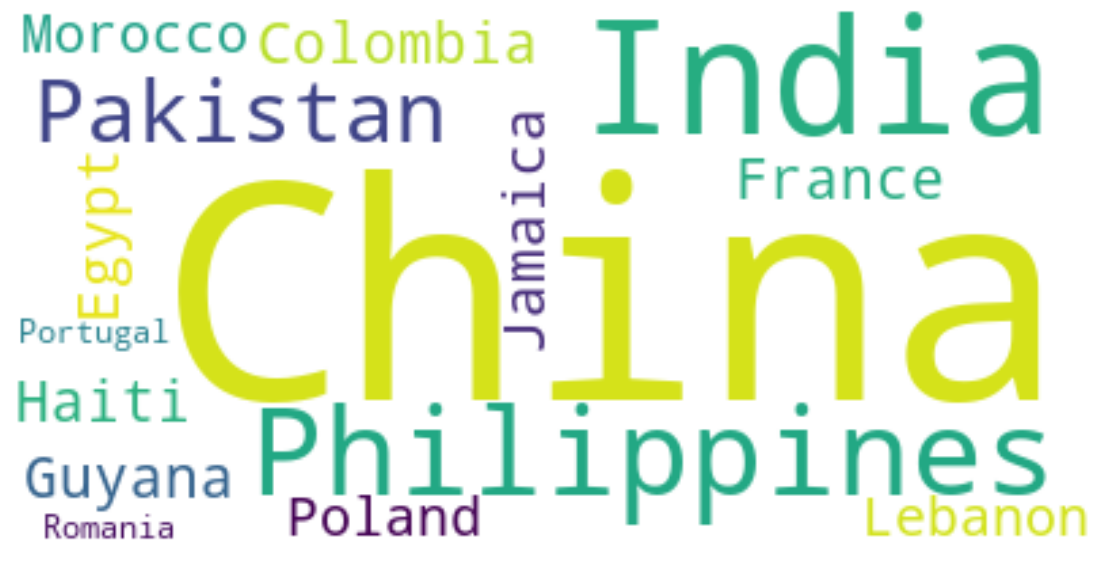

In [30]:
# display the cloud
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(8)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');
#plt.show

Theo word cloud ở trên, có vẻ như phần lớn những người nhập cư đến từ một trong 15 quốc gia được hiển thị bởi word cloud. Một hình ảnh thú vị mà bạn có thể xây dựng, có lẽ là sử dụng bản đồ của Canada và một chiếc mặt nạ và chồng word cloud lên trên bản đồ của Canada. Đó sẽ là một hình ảnh xây lên sẽ rất thú vị!

# Sơ đồ hồi quy <a id="10"></a>

> Seaborn là thư viện trực quan hóa của Python dựa trên matplotlib. Nó cung cấp các giao diện bậc cao để vẽ các biểu đồ thống kê thú vị. Bạn có thể tìm hiểu thêm về _seaborn_ trong [link](https://seaborn.pydata.org?cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork-20297740&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ&cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork-20297740&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ&cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork-20297740&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ&cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork-20297740&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ) sau và về _sơ đồ hồi quy seaborn_ theo [link](http://seaborn.pydata.org/generated/seaborn.regplot.html?cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork-20297740&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ&cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork-20297740&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ&cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork-20297740&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ&cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork-20297740&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ).


Trong bài lab Biểu đồ tròn, biểu đồ hộp, biểu đồ phân tán và biểu đồ bong bóng, chúng ta đã học cách tạo biểu đồ phân tán và khớp nó vào các đường hồi quy. Nó mất gần 20 dòng code để tạo biểu đồ phân tán cùng với khớp hồi quy. Trong phần cuối này, chúng ta sẽ khám phá seaborn và xem mức độ hiệu quả khi tạo các đường và khớp hồi quy bằng thư viện này!

In [31]:
# install seaborn
# !pip3 install seaborn

# import library
import seaborn as sns

print('Seaborn installed and imported!')

Seaborn installed and imported!


In [32]:
# we can use the sum() method to get the total population per year
df_tot = pd.DataFrame(df_can[years].sum(axis=0))

# change the years to type float (useful for regression later on)
df_tot.index = map(float, df_tot.index)

# reset the index to put in back in as a column in the df_tot dataframe
df_tot.reset_index(inplace=True)

# rename columns
df_tot.columns = ['year', 'total']

# view the final dataframe
df_tot.head()

,year,total
0,1980.0,99137
1,1981.0,110563
2,1982.0,104271
3,1983.0,75550
4,1984.0,73417


Với seaborn, tạo một sơ đồ hồi quy đơn giản như là gọi hàm **regplot**.

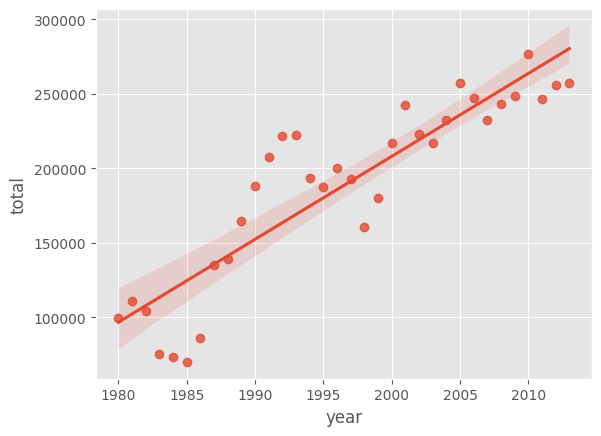

In [33]:
import seaborn as sns

ax = sns.regplot(x='year', y='total', data = df_tot)

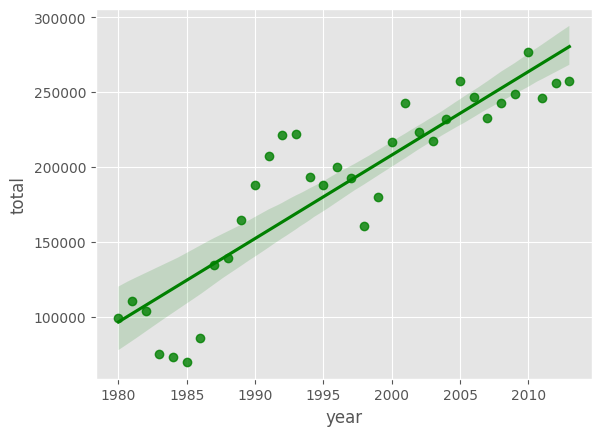

In [34]:
import seaborn as sns
ax = sns.regplot(x='year', y='total', data=df_tot, color='green') # color changed

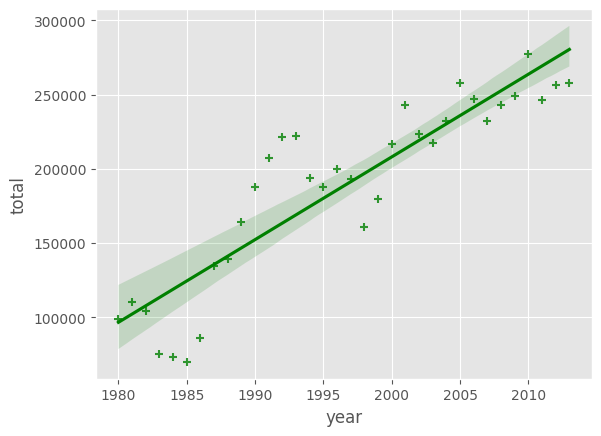

In [35]:
import seaborn as sns
ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+') # custom marker

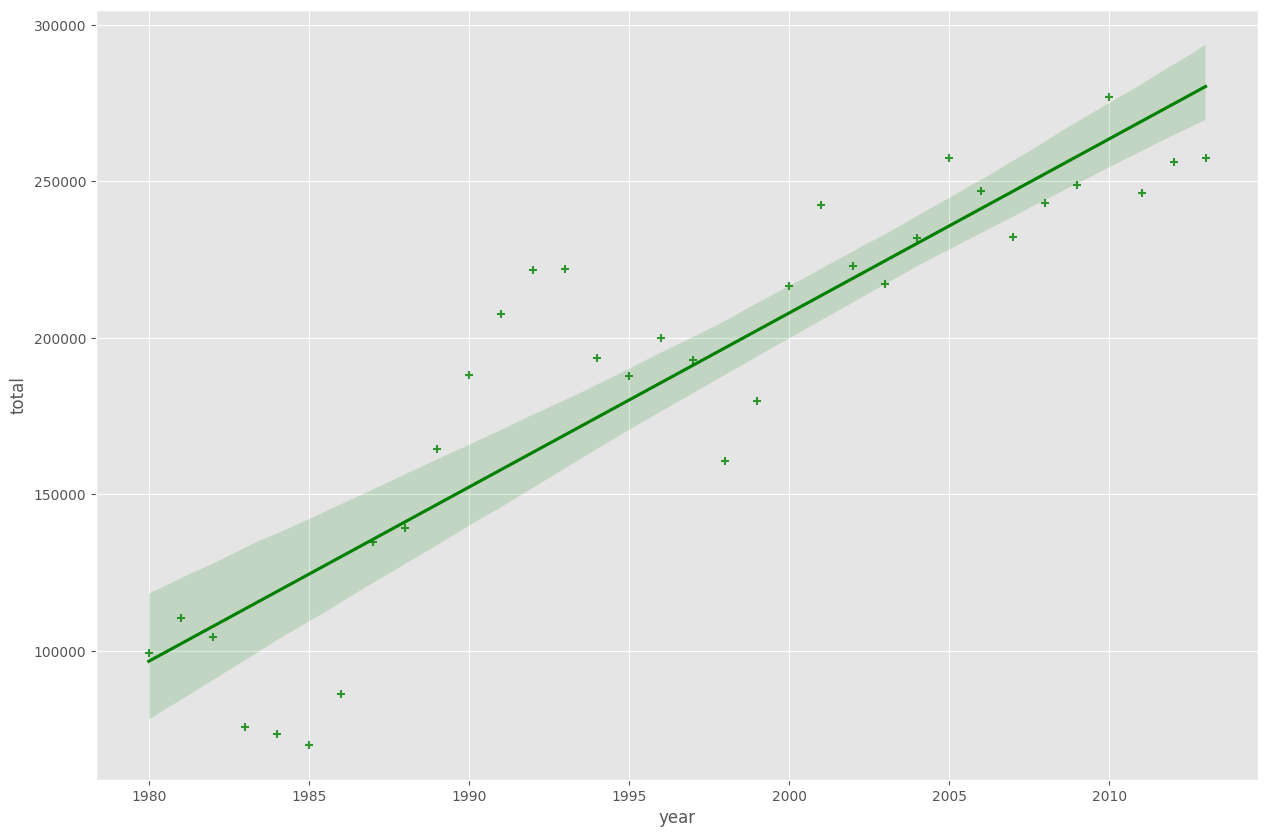

In [36]:
plt.figure(figsize=(15, 10))
ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+') # figsize

Và hãy tăng kích thước của các điểm đánh dấu để chúng phù hợp với kích thước mới của hình, đồng thời thêm tiêu đề và các nhãn x- và y.


Text(0.5, 1.0, 'Total Immigration to Canada from 1980 - 2013')

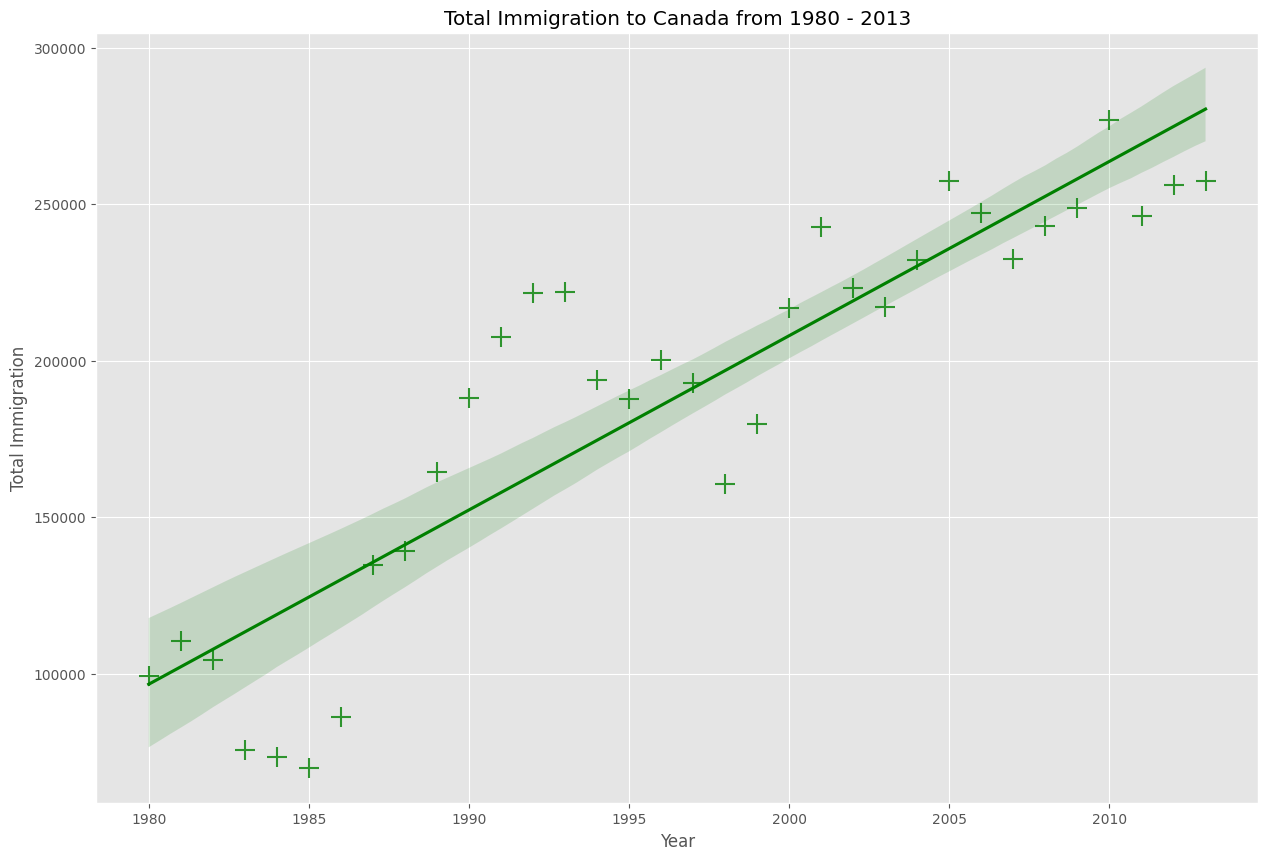

In [37]:
plt.figure(figsize=(15, 10))
ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})

ax.set(xlabel='Year', ylabel='Total Immigration') # add x- and y-labels
ax.set_title('Total Immigration to Canada from 1980 - 2013') # add title

Và cuối cùng, hãy tăng kích thước phông chữ của các nhãn đánh dấu, tiêu đề và các nhãn x- và y để chúng trông phù hợp với các nội dung khác!

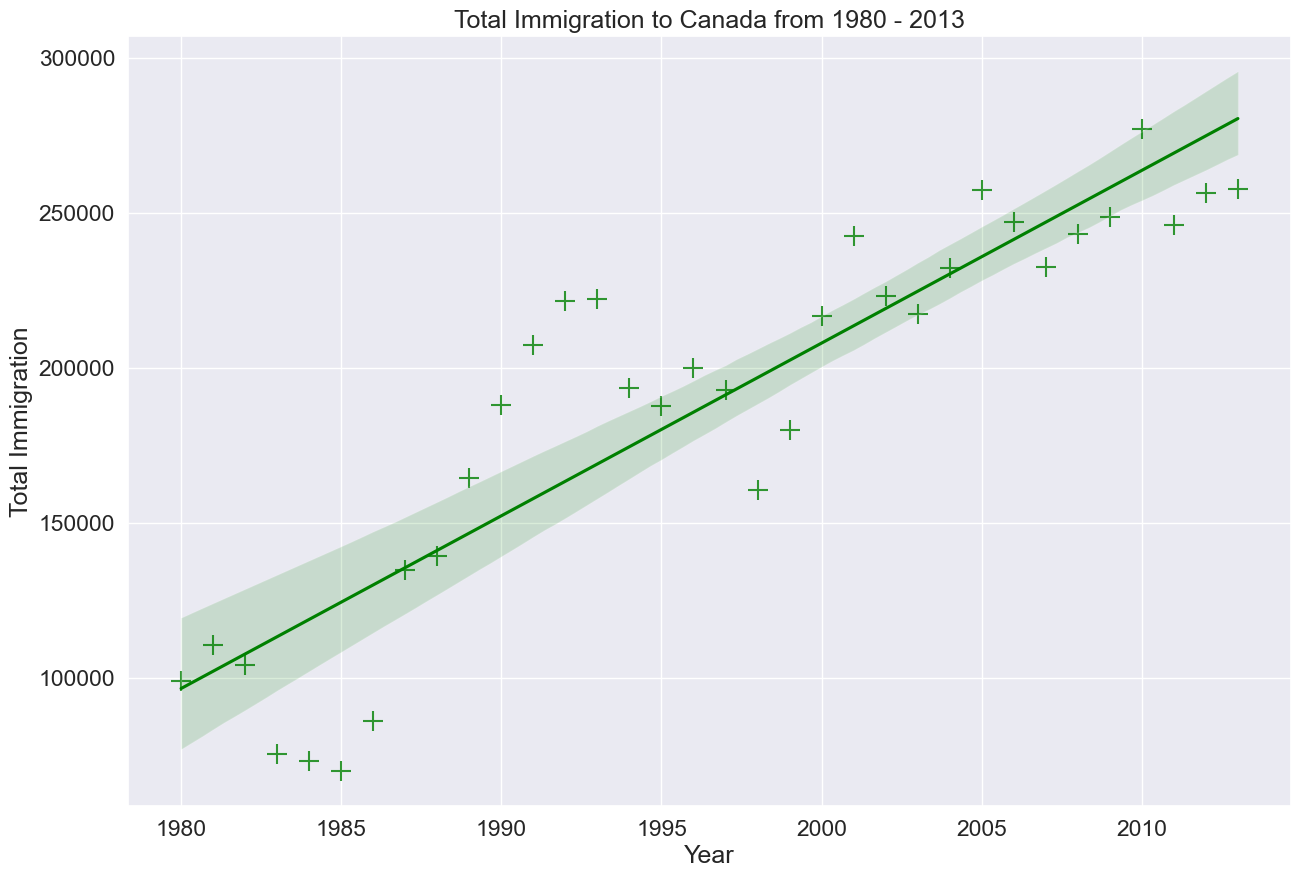

In [38]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)

ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigration to Canada from 1980 - 2013');

In [39]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

Text(0.5, 1.0, 'Total Immigration to Canada from 1980 - 2013')

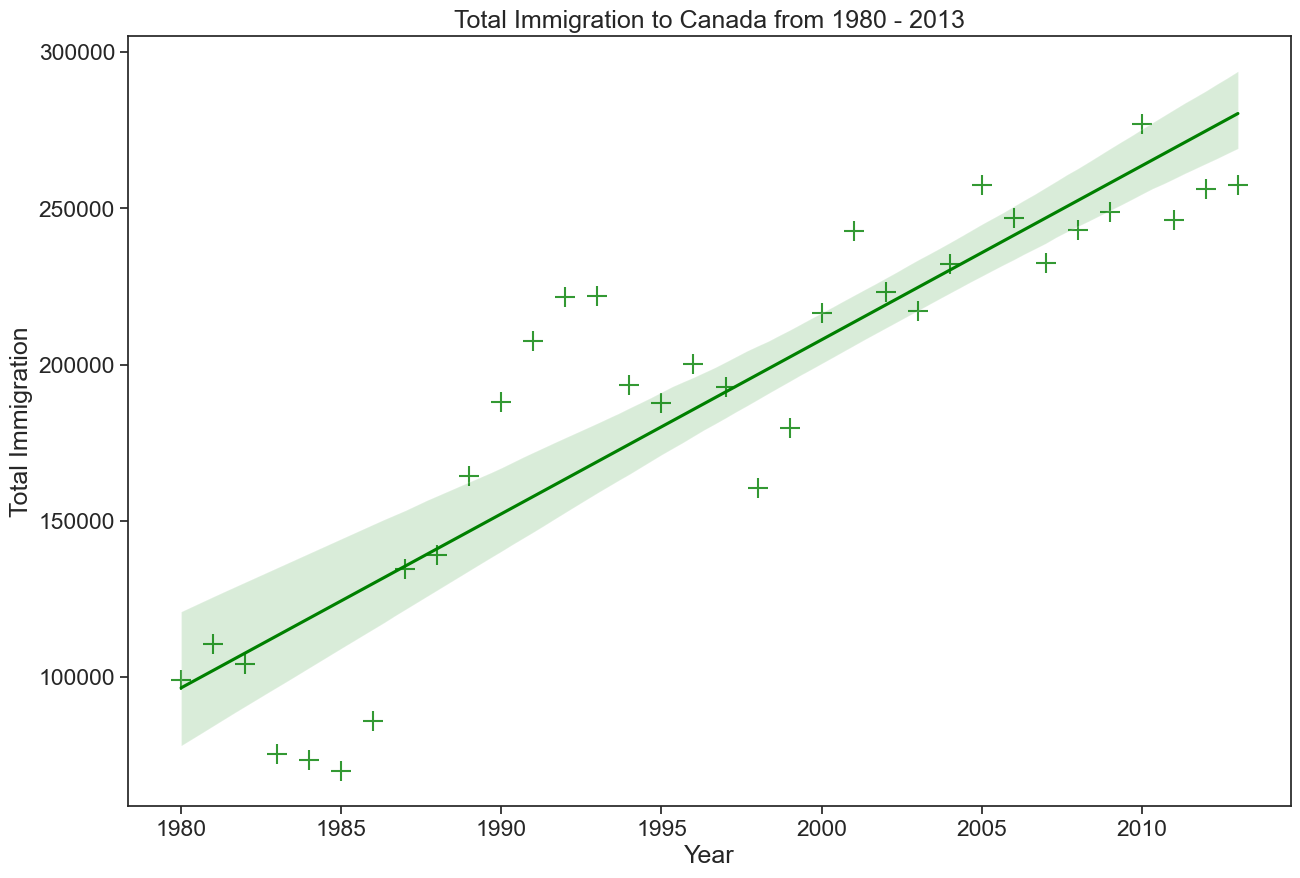

In [40]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)
sns.set_style('ticks') # change background to white background

ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigration to Canada from 1980 - 2013')

Text(0.5, 1.0, 'Total Immigration to Canada from 1980 - 2013')

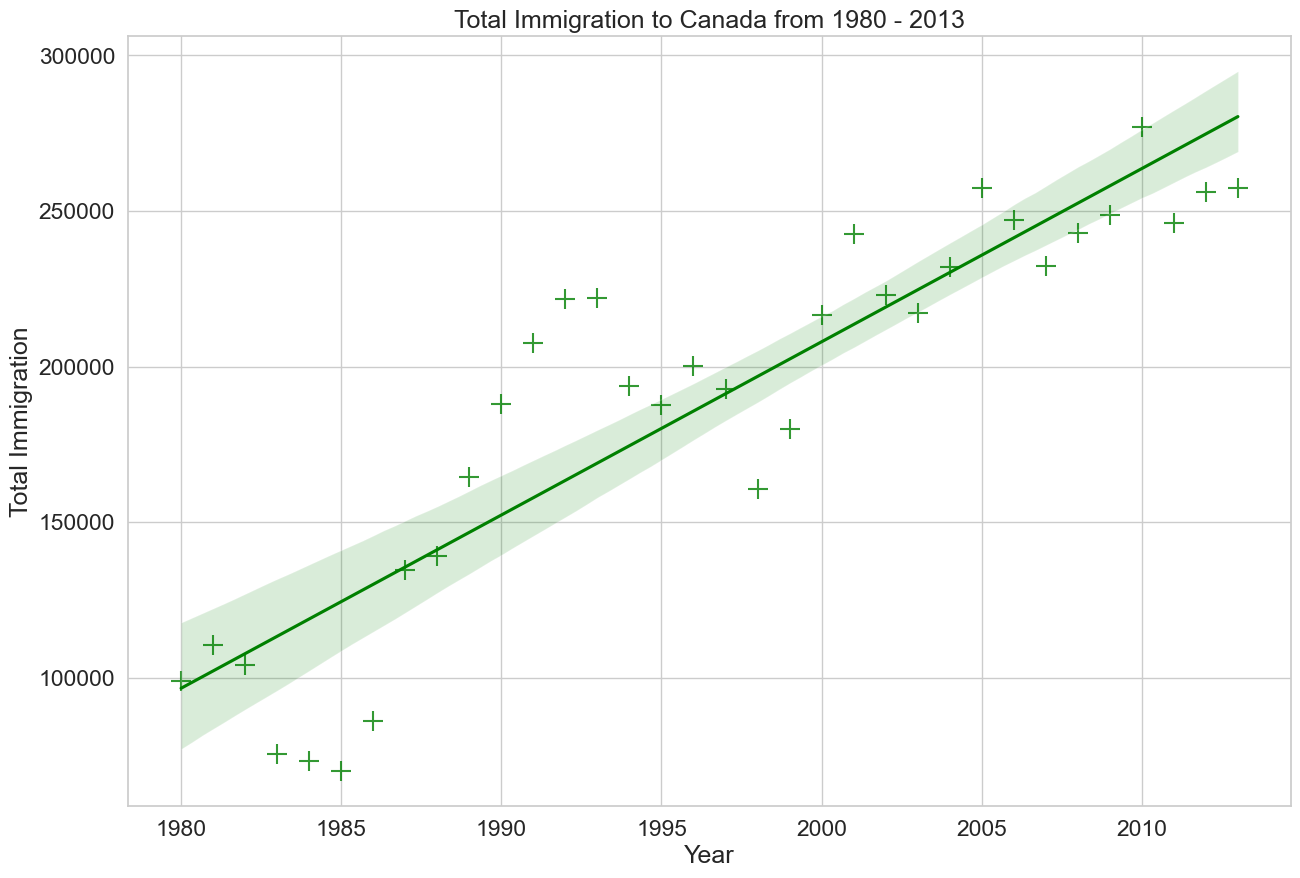

In [41]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)
sns.set_style('whitegrid')

ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigration to Canada from 1980 - 2013')

**Câu hỏi: Sử dụng seaborn để tạo biểu đồ phân tán với đường hồi quy để hình dung tổng lượng nhập cư từ Đan Mạch, Thụy Điển và Na Uy đến Canada từ năm 1980 đến năm 2013.**

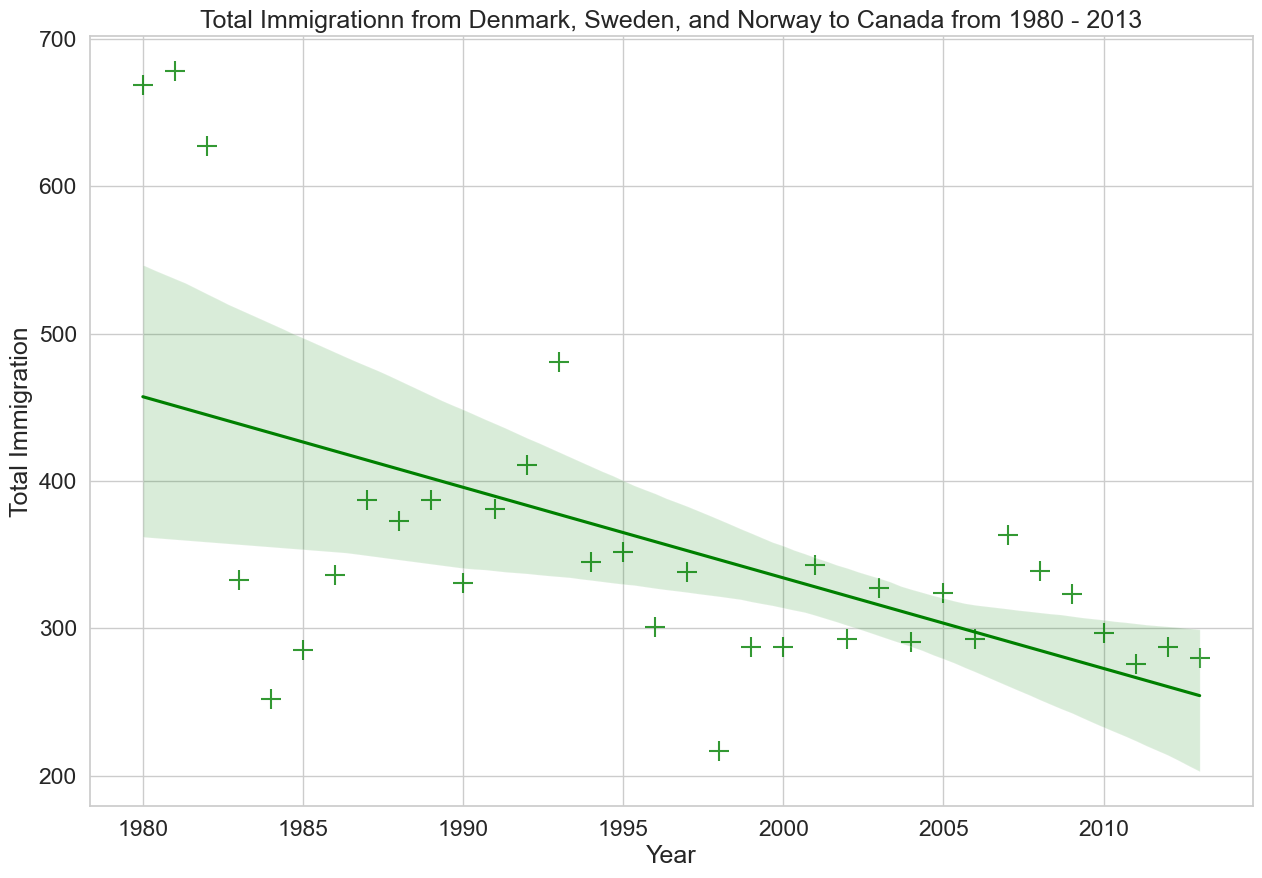

In [42]:
    # create df_countries dataframe
    df_countries = df_can.loc[['Denmark', 'Norway', 'Sweden'], years].transpose()

    # create df_total by summing across three countries for each year
    df_total = pd.DataFrame(df_countries.sum(axis=1))

    # reset index in place
    df_total.reset_index(inplace=True)

    # rename columns
    df_total.columns = ['year', 'total']

    # change column year from string to int to create scatter plot
    df_total['year'] = df_total['year'].astype(int)

    # define figure size
    plt.figure(figsize=(15, 10))

    # define background style and font size
    sns.set(font_scale=1.5)
    sns.set_style('whitegrid')

    # generate plot and add title and axes labels
    ax = sns.regplot(x='year', y='total', data=df_total, color='green', marker='+', scatter_kws={'s': 200})
    ax.set(xlabel='Year', ylabel='Total Immigration')
    ax.set_title('Total Immigrationn from Denmark, Sweden, and Norway to Canada from 1980 - 2013');
    